Preprocessing Data

Loading library

In [ ]:
import os
import pandas as pd
import numpy as np
import librosa
import librosa.display as lid
import matplotlib.pyplot as plt
import IPython.display as ipd
from matplotlib import cm
from tqdm import tqdm
tqdm.pandas()
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision import models
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import random


Configuration for function

In [ ]:
class CFG:
    # General Settings
    seed = 42; epochs = 10; augment = True; batch_size = 64

    # Audio Settings
    duration = 15; sample_rate = 32000
    audio_len = duration * sample_rate
    nfft = 2028; window = 1024; fmin = 20; fmax = 16000

    # Spectrogram Settings
    img_size = [128, 384]; hop_length = audio_len // (img_size[1] - 1)

    # Model
    preset = 'efficientnetv2_b2_imagenet'


Loading data

In [ ]:
DATA_DIR = 'E:/Desktop/BU/2025 Spring/MA679_Bird2025/'
train_meta = pd.read_csv(os.path.join(DATA_DIR, 'train.csv'))
submission_path = 'sample_submission.csv'
sub = pd.read_csv(submission_path)

# Label info
class_names = sorted(train_meta['primary_label'].unique())
name2id = {name: i for i, name in enumerate(class_names)}
id2name = {i: name for name, i in name2id.items()}
# Setup paths for sample submission
soundscape_dir = 'train_soundscapes'
output_dir = 'Local/test_spectrograms'
os.makedirs(output_dir, exist_ok=True)


Brief info about the file.

In [32]:
train_meta.head()

,primary_label,secondary_labels,type,filename,collection,rating,url,latitude,longitude,scientific_name,common_name,author,license
0,1139490,[''],[''],1139490/CSA36385.ogg,CSA,0.0,http://colecciones.humboldt.org.co/rec/sonidos...,7.3206,-73.7128,Ragoniella pulchella,Ragoniella pulchella,Fabio A. Sarria-S,cc-by-nc-sa 4.0
1,1139490,[''],[''],1139490/CSA36389.ogg,CSA,0.0,http://colecciones.humboldt.org.co/rec/sonidos...,7.3206,-73.7128,Ragoniella pulchella,Ragoniella pulchella,Fabio A. Sarria-S,cc-by-nc-sa 4.0
2,1192948,[''],[''],1192948/CSA36358.ogg,CSA,0.0,http://colecciones.humboldt.org.co/rec/sonidos...,7.3791,-73.7313,Oxyprora surinamensis,Oxyprora surinamensis,Fabio A. Sarria-S,cc-by-nc-sa 4.0
3,1192948,[''],[''],1192948/CSA36366.ogg,CSA,0.0,http://colecciones.humboldt.org.co/rec/sonidos...,7.2800,-73.8582,Oxyprora surinamensis,Oxyprora surinamensis,Fabio A. Sarria-S,cc-by-nc-sa 4.0
4,1192948,[''],[''],1192948/CSA36373.ogg,CSA,0.0,http://colecciones.humboldt.org.co/rec/sonidos...,7.3791,-73.7313,Oxyprora surinamensis,Oxyprora surinamensis,Fabio A. Sarria-S,cc-by-nc-sa 4.0


Functions:
1: Extracting Mel specturm
2: Loading audio
3: audio to mel
4: Mel to iamge

In [42]:
def extract_mel_label(row):
    try:
        filepath = os.path.join(DATA_DIR, 'train_audio', row['filename'])
        audio, _ = load_audio(filepath)
        mel = audio_to_mel(audio)
        label = name2id[row['primary_label']]
        return mel, label
    except Exception as e:
        print(f"Error processing {filepath}: {e}")
        return None, None


def load_audio(filepath):
    audio, sr = librosa.load(filepath, sr=CFG.sample_rate)
    if len(audio) < CFG.audio_len:
        audio = np.pad(audio, (0, CFG.audio_len - len(audio)))
    else:
        audio = audio[:CFG.audio_len]
    return audio, sr

def audio_to_mel(audio):
    mel = librosa.feature.melspectrogram(
        y=audio,
        sr=CFG.sample_rate,
        n_fft=CFG.nfft,
        hop_length=CFG.hop_length,
        win_length=CFG.window,
        n_mels=CFG.img_size[0],
        fmin=CFG.fmin,
        fmax=CFG.fmax
    )
    mel_db = librosa.power_to_db(mel, ref=np.max)
    mel_db -= mel_db.min()
    mel_db /= mel_db.max()
    return mel_db

def save_mel_as_image(mel, save_path):
    plt.figure(figsize=(4, 2))
    plt.axis('off')
    librosa.display.specshow(mel, sr=CFG.sample_rate, hop_length=CFG.hop_length,
                             x_axis='time', y_axis='mel', cmap='magma')
    plt.savefig(save_path, bbox_inches='tight', pad_inches=0)
    plt.close()


Display sample 1

Mel shape: (128, 384)
Label (class id): 0 | Label name: 1139490


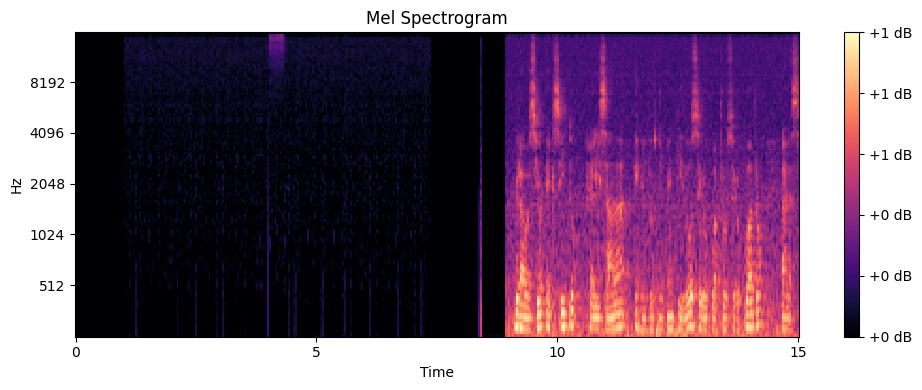

In [67]:
row = train_meta.iloc[0]

# Extract mel and label
mel, label = extract_mel_label(row)

# Check if successful
if mel is not None:
    print("Mel shape:", mel.shape)
    print("Label (class id):", label, "| Label name:", id2name[label])

    # Plot the mel spectrogram
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(mel, sr=CFG.sample_rate, hop_length=CFG.hop_length,
                             fmin=CFG.fmin, fmax=CFG.fmax,
                             x_axis='time', y_axis='mel', cmap='magma')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Mel Spectrogram')
    plt.tight_layout()
    plt.show()

Save Mel spectrum as figure
Tesing sample size 20

In [59]:
for i in range(20):
    row = train_meta.iloc[i]
    filepath = os.path.join(DATA_DIR, 'train_audio', row['filename'])
    
    try:
        audio, sr = load_audio(filepath)
        mel = audio_to_mel(audio)
        
        plt.figure(figsize=(4, 2))
        plt.axis('off')
        librosa.display.specshow(mel, sr=sr, hop_length=CFG.hop_length,
                                 x_axis='time', y_axis='mel', cmap='magma')
        plt.savefig(f'Local/{i:02d}_{row["primary_label"]}.png', bbox_inches='tight', pad_inches=0)
        plt.close()
    except Exception as e:
        print(f"Error with {filepath}: {e}")

Small sample size(20) of CNN


In [ ]:

# ResNet (224*224)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Dataset Class to Load Images and Extract Labels 
class SpectrogramImageDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.image_files = [f for f in os.listdir(image_dir) if f.endswith(".png")]
        self.transform = transform
        self.class_names = sorted(list({f.split('_')[1].split('.')[0] for f in self.image_files}))
        self.name2id = {name: i for i, name in enumerate(self.class_names)}
    
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        file = self.image_files[idx]
        img_path = os.path.join(self.image_dir, file)
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        label_name = file.split('_')[1].split('.')[0]
        label = torch.tensor(self.name2id[label_name])
        return image, label

# Load Dataset 
dataset = SpectrogramImageDataset('Local', transform=transform)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

#  Load Pretrained ResNet18
model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
model.fc = nn.Linear(model.fc.in_features, len(dataset.class_names))  # num_classes = bird species
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

#  Optimizer and Loss 
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# Training Loop (3 epochs)
model.train()
for epoch in range(3):
    total_loss = 0.0
    correct = 0
    total = 0
    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)
        # cfg
        optimizer.zero_grad()
        outputs = model(images)
        
        loss = criterion(outputs, labels)
        loss.backward()
        
        optimizer.step()
        total_loss += loss.item()
        
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    acc = 100 * correct / total
    print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}, Accuracy: {acc:.2f}%")


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\mlsdb/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:03<00:00, 13.0MB/s]


Epoch 1, Loss: 7.8677, Accuracy: 35.00%
Epoch 2, Loss: 3.3243, Accuracy: 85.00%
Epoch 3, Loss: 2.3641, Accuracy: 95.00%


Using one sample as prediction

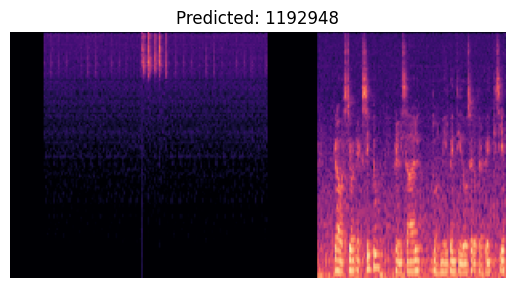

'1192948'

In [49]:
def predict_image(img_path):
    model.eval()
    image = Image.open(img_path).convert("RGB")
    image_tensor = transform(image).unsqueeze(0).to(device)  # [1, C, H, W]
    output = model(image_tensor)
    pred_idx = torch.argmax(output, dim=1).item()
    pred_class = dataset.class_names[pred_idx]

    # Display
    plt.imshow(image)
    plt.title(f"Predicted: {pred_class}")
    plt.axis('off')
    plt.show()
    
    return pred_class

# Example usage
predict_image('Local/03_1192948.png')

Sample submission generating format

In [ ]:

sample_file = next(f for f in os.listdir(soundscape_dir) if f.endswith('.ogg'))
audio_path = os.path.join(soundscape_dir, sample_file)
img_path = os.path.join(output_dir, sample_file.replace('.ogg', '.jpg'))

# Convert to Mel Spectrogram 
def audio_to_mel_image(audio_path, save_path):
    y, sr = librosa.load(audio_path, sr=CFG.sample_rate)
    y = y[:CFG.audio_len]
    mel = librosa.feature.melspectrogram(
        y=y,
        sr=CFG.sample_rate,
        n_fft=CFG.nfft,
        hop_length=CFG.hop_length,
        win_length=CFG.window,
        n_mels=CFG.img_size[0],
        fmin=CFG.fmin,
        fmax=CFG.fmax
    )
    mel_db = librosa.power_to_db(mel, ref=np.max)
    mel_img = (mel_db - mel_db.min()) / (mel_db.max() - mel_db.min())
    plt.imsave(save_path, mel_img, cmap='viridis')

# Create spectrogram image
audio_to_mel_image(audio_path, img_path)

# Inference
image = Image.open(img_path).convert('RGB')
image_tensor = transform(image).unsqueeze(0).to(device)

model.eval()
with torch.no_grad():
    output = model(image_tensor)
    probs = torch.sigmoid(output).squeeze().cpu().numpy()

sub = pd.read_csv('sample_submission.csv')

for i, col in enumerate(sub.columns[1:]):
    sub[col] = probs[i] if i < len(probs) else 0.0

# Save final submission
sub.to_csv('submission1.csv', index=False)
print(f"submission1.csv saved using {sample_file}")


✅ submission1.csv saved using H02_20230420_074000.ogg
